# Exploratory Data Analysis

In [11]:
#Importing all the neccessary libraries
import pandas as pd
import numpy as np

#Libraries for visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

#Libraries for formattting and handling text 
import string
import re

#Library for nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer
from nltk import word_tokenize
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from collections import Counter
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")


In [12]:
df = pd.read_csv('chatgpt.csv')
df.head()

,tweet_id,created_at,like_count,quote_count,reply_count,retweet_count,tweet,country,photo_url,city,country_code
0,1598014056790622225,2022-11-30 18:00:15+00:00,2,0,0,0,ChatGPT: Optimizing Language Models for Dialog...,NaN,NaN,NaN,NaN
1,1598014522098208769,2022-11-30 18:02:06+00:00,12179,889,1130,3252,"Try talking with ChatGPT, our new AI system wh...",NaN,NaN,NaN,NaN
2,1598014741527527435,2022-11-30 18:02:58+00:00,2,0,0,1,ChatGPT: Optimizing Language Models for Dialog...,NaN,https://pbs.twimg.com/media/Fi1J8HbWAAMv_yi.jpg,NaN,NaN
3,1598015493666766849,2022-11-30 18:05:58+00:00,561,8,25,66,"THRILLED to share that ChatGPT, our new model ...",NaN,https://pbs.twimg.com/media/Fi1Km3WUYAAfzHS.jpg,NaN,NaN
4,1598015509420994561,2022-11-30 18:06:01+00:00,1,0,0,0,"As of 2 minutes ago, @OpenAI released their ne...",NaN,NaN,NaN,NaN


In [13]:
df.isnull().sum()

tweet_id              0
created_at            0
like_count            0
quote_count           0
reply_count           0
retweet_count         0
tweet                 0
country          215646
photo_url        150848
city             215646
country_code     215649
dtype: int64

Drop columns with lots of missing values

In [14]:
df=df.drop(['country','photo_url','city','country_code'],axis=1)
df.head()

,tweet_id,created_at,like_count,quote_count,reply_count,retweet_count,tweet
0,1598014056790622225,2022-11-30 18:00:15+00:00,2,0,0,0,ChatGPT: Optimizing Language Models for Dialog...
1,1598014522098208769,2022-11-30 18:02:06+00:00,12179,889,1130,3252,"Try talking with ChatGPT, our new AI system wh..."
2,1598014741527527435,2022-11-30 18:02:58+00:00,2,0,0,1,ChatGPT: Optimizing Language Models for Dialog...
3,1598015493666766849,2022-11-30 18:05:58+00:00,561,8,25,66,"THRILLED to share that ChatGPT, our new model ..."
4,1598015509420994561,2022-11-30 18:06:01+00:00,1,0,0,0,"As of 2 minutes ago, @OpenAI released their ne..."


# Feature extraction

In [15]:
data=df.copy()

### Number of words

In [16]:
def number_of_words(data):
    data['word_count'] = data['tweet'].apply(lambda x : len(str(x).split(" ")))

### Number of characters

In [17]:
def char_count(text):
    charc=0
    for char in text.split():
        charc +=len(char)
    return charc

### Number of stopwords

In [18]:
stop_words = stopwords.words('english')

def num_of_stopwords(data):
    data['stopwords_count'] = data['tweet'].apply(lambda x: len([x for x in x.split() if x in stop_words]))

### Number of hashtags

In [19]:
def num_of_hashtags(data):
    data['hashtag_count'] = data['tweet'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))


In [20]:
def feat_extract(data):
    num_of_hashtags(data)
    number_of_words(data)
    data['char_count']=data['tweet'].apply(char_count)
    num_of_stopwords(data)

# Text pre-processing

### Remove emojis

In [21]:
def remove_emoji(string):
        emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', string) 

### Remove links

In [22]:
def hyperlinks(text):
    temp = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.',text)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub('&gt;', "", temp) # greater than sign
    temp = re.sub('&#x27;', "'", temp) # apostrophe
    temp = re.sub('&#x2F;', ' ', temp)
    temp = re.sub('<p>', ' ', temp) # paragraph tag
    temp = re.sub('<i>', ' ', temp) #italics tag
    temp = re.sub('</i>', '', temp) 
    temp = re.sub('&#62;', '', temp)
    temp = re.sub("\n", '', temp) # newline 
    return temp

### General cleaning and remove stopwords

In [23]:
def clean_tweet(tweet):
    temp=tweet.lower()
    temp = re.sub("'", "", temp) # to avoid removing contractions in english
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub("chatgpt","",temp)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    punc=string.punctuation
    temp=temp.translate(str.maketrans('','',punc))
    
    #removing stopwords
    new_list=[]
    words=word_tokenize(temp)
    sws=stopwords.words('english')
    for word in words:
        if word not in sws:
            new_list.append(word)
    
    temp=' '.join(new_list)
    return temp

### Spelling correction

In [24]:
def spell_correct(data):
    data['tweet'].apply(lambda x: str(TextBlob(x).correct()))

### Lemmatization

In [25]:
def lemmatize(text):    
    new_list=[]
    lemma=WordNetLemmatizer()
    words=word_tokenize(text)
    for word in words:
        new_list.append(lemma.lemmatize(word))
    
    return ' '.join(new_list)

In [26]:
feat_extract(data)

data['tweet'] = data['tweet'].apply(hyperlinks)
data['tweet'] = data['tweet'].apply(remove_emoji)
data['tweet'] = data['tweet'].apply(clean_tweet)
data['final_tweet'] = data['tweet'].apply(lemmatize)

In [27]:
data.head()

,tweet_id,created_at,like_count,quote_count,reply_count,retweet_count,tweet,hashtag_count,word_count,char_count,stopwords_count,final_tweet
0,1598014056790622225,2022-11-30 18:00:15+00:00,2,0,0,0,optimizing language models dialogue,0,8,73,1,optimizing language model dialogue
1,1598014522098208769,2022-11-30 18:02:06+00:00,12179,889,1130,3252,try talking new ai system optimized dialogue f...,0,21,119,6,try talking new ai system optimized dialogue f...
2,1598014741527527435,2022-11-30 18:02:58+00:00,2,0,0,1,optimizing language models dialogue ai machine...,4,26,239,3,optimizing language model dialogue ai machinel...
3,1598015493666766849,2022-11-30 18:05:58+00:00,561,8,25,66,thrilled share new model optimized dialog publ...,0,22,167,8,thrilled share new model optimized dialog publ...
4,1598015509420994561,2022-11-30 18:06:01+00:00,1,0,0,0,2 minutes ago released new nnand use right,0,20,120,6,2 minute ago released new nnand use right


# Sentiment Analysis

In [28]:
sid=SentimentIntensityAnalyzer()

In [29]:
data['sentiment_compound_polarity']=data.final_tweet.apply(lambda x:sid.polarity_scores(x)['compound'])
data['sentiment_neutral']=data.final_tweet.apply(lambda x:sid.polarity_scores(x)['neu'])
data['sentiment_negative']=data.final_tweet.apply(lambda x:sid.polarity_scores(x)['neg'])
data['sentiment_pos']=data.final_tweet.apply(lambda x:sid.polarity_scores(x)['pos'])
data['sentiment_type']=''

data.loc[data.sentiment_compound_polarity>0,'sentiment_type']='POSITIVE'
data.loc[data.sentiment_compound_polarity==0,'sentiment_type']='NEUTRAL'
data.loc[data.sentiment_compound_polarity<0,'sentiment_type']='NEGATIVE'
data.head()

,tweet_id,created_at,like_count,quote_count,reply_count,retweet_count,tweet,hashtag_count,word_count,char_count,stopwords_count,final_tweet,sentiment_compound_polarity,sentiment_neutral,sentiment_negative,sentiment_pos,sentiment_type
0,1598014056790622225,2022-11-30 18:00:15+00:00,2,0,0,0,optimizing language models dialogue,0,8,73,1,optimizing language model dialogue,0.4588,0.500,0.0,0.500,POSITIVE
1,1598014522098208769,2022-11-30 18:02:06+00:00,12179,889,1130,3252,try talking new ai system optimized dialogue f...,0,21,119,6,try talking new ai system optimized dialogue f...,0.8225,0.449,0.0,0.551,POSITIVE
2,1598014741527527435,2022-11-30 18:02:58+00:00,2,0,0,1,optimizing language models dialogue ai machine...,4,26,239,3,optimizing language model dialogue ai machinel...,0.4588,0.857,0.0,0.143,POSITIVE
3,1598015493666766849,2022-11-30 18:05:58+00:00,561,8,25,66,thrilled share new model optimized dialog publ...,0,22,167,8,thrilled share new model optimized dialog publ...,0.8860,0.345,0.0,0.655,POSITIVE
4,1598015509420994561,2022-11-30 18:06:01+00:00,1,0,0,0,2 minutes ago released new nnand use right,0,20,120,6,2 minute ago released new nnand use right,0.0000,1.000,0.0,0.000,NEUTRAL


<AxesSubplot:ylabel='sentiment_type'>

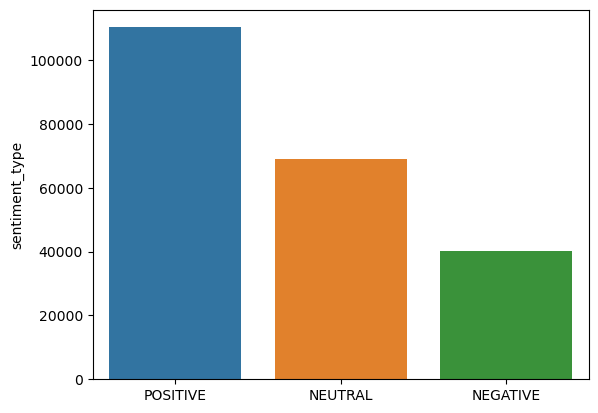

In [30]:
sns.barplot(data=data,x=data['sentiment_type'].value_counts().index,y=data['sentiment_type'].value_counts())

In [31]:
fig = go.Figure(go.Funnelarea(
    text =data['sentiment_type'].value_counts().index,
    values = data['sentiment_type'].value_counts(),
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

In [116]:
eda=data.copy()

eda['temp_list'] = eda['final_tweet'].apply(lambda x:str(x).split())
top = Counter([item for sublist in eda['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(30))
temp.drop([1],inplace=True)
temp.drop([9],inplace=True)
temp.drop([12],inplace=True)
temp.columns = ['Common_words','count']

In [117]:
#bar plot using plotly.express
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [34]:
#tree map using plotly.express
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

In [35]:
pos=eda[eda['sentiment_type']=='POSITIVE']
neg=eda[eda['sentiment_type']=='NEGATIVE']
neu=eda[eda['sentiment_type']=='NEUTRAL']

In [36]:
#most common positive words
top = Counter([item for sublist in pos['temp_list'] for item in sublist])
temp_pos = pd.DataFrame(top.most_common(30))
temp_pos.columns = ['Common_words','count']
temp_pos.style.background_gradient(cmap='Greens')

,Common_words,count
0,ai,28593
1,’,18046
2,like,14573
3,openai,8146
4,new,7940
5,write,7677
6,good,7409
7,asked,6996
8,use,6570
9,using,6251


In [37]:
#tree map using plotly.express
fig = px.treemap(temp_pos, path=['Common_words'], values='count',title='Most Common Positive Words')
fig.show()

In [38]:
#most common negative words
top = Counter([item for sublist in pos['temp_list'] for item in sublist])
temp_neg = pd.DataFrame(top.most_common(30))
temp_neg.columns = ['Common_words','count']
temp_neg.style.background_gradient(cmap='Reds')

,Common_words,count
0,ai,28593
1,’,18046
2,like,14573
3,openai,8146
4,new,7940
5,write,7677
6,good,7409
7,asked,6996
8,use,6570
9,using,6251


In [39]:
fig = px.treemap(temp_neg, path=['Common_words'], values='count',title='Most Common Negative Words')
fig.show()

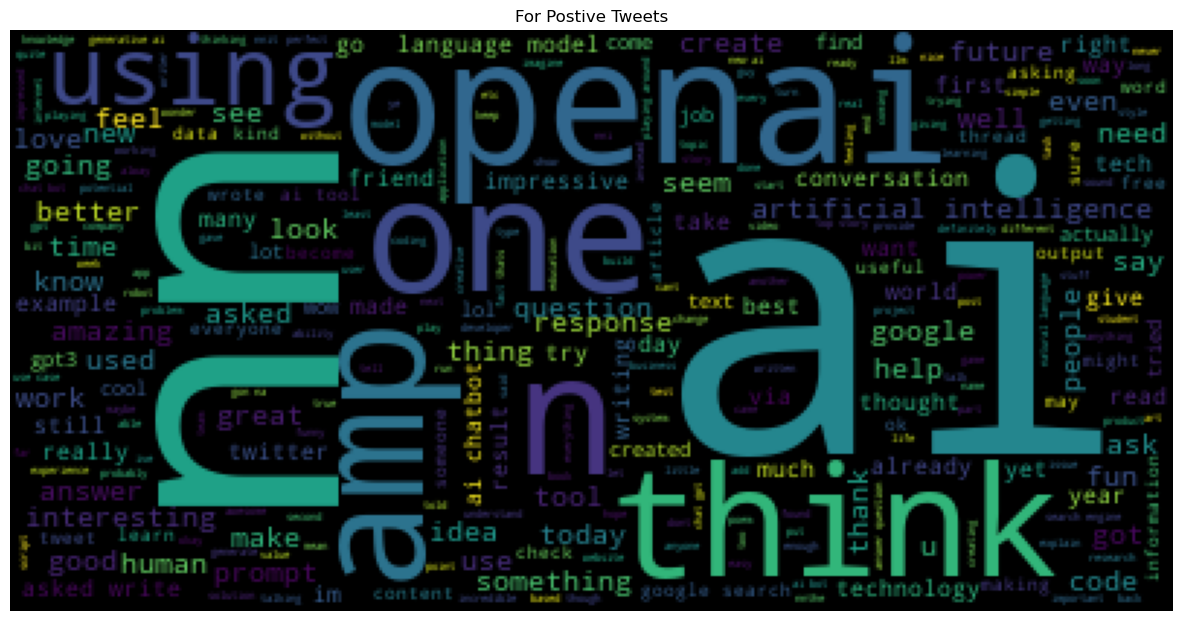

In [40]:
plt.figure(figsize=(15,10))
text=' '.join(eda[eda['sentiment_type']=='POSITIVE']['final_tweet'])
wordcloud=WordCloud(max_words=500,background_color='black',colormap='viridis').generate(text)
plt.imshow(wordcloud)
plt.axis('off')
plt.title('For Postive Tweets')
plt.show()

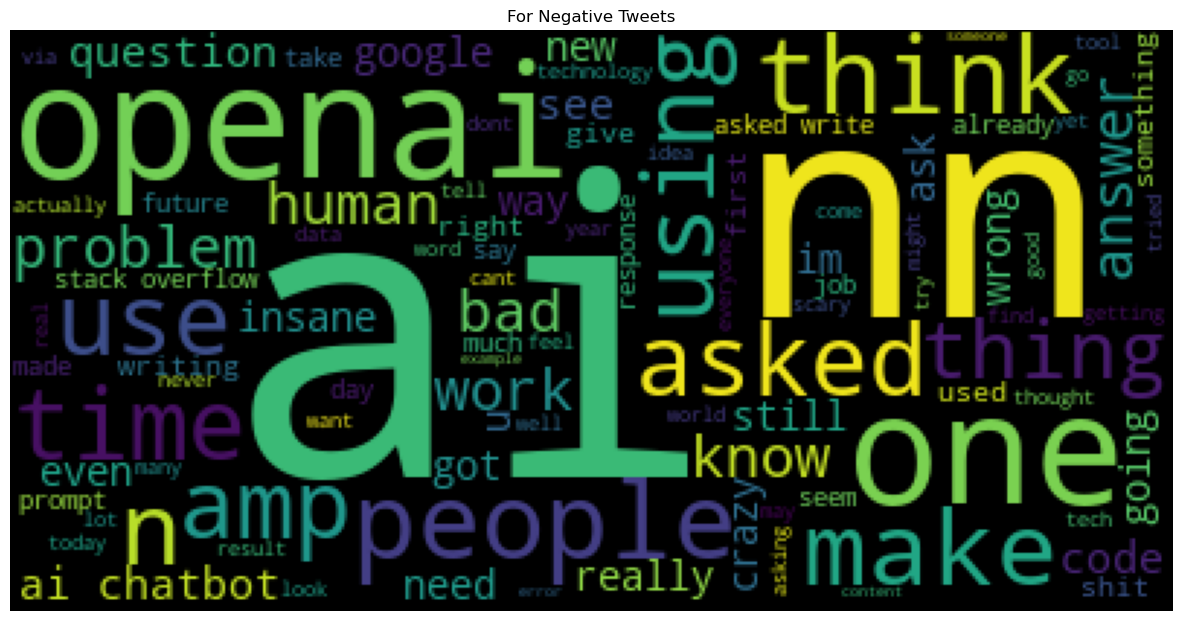

In [41]:
plt.figure(figsize=(15,10))
text=' '.join(eda[eda['sentiment_type']=='NEGATIVE']['final_tweet'])
wordcloud=WordCloud(max_words=100,background_color='black',colormap='viridis').generate(text)
plt.imshow(wordcloud)
plt.axis('off')
plt.title('For Negative Tweets')
plt.show()

### Word-level sentiment analysis

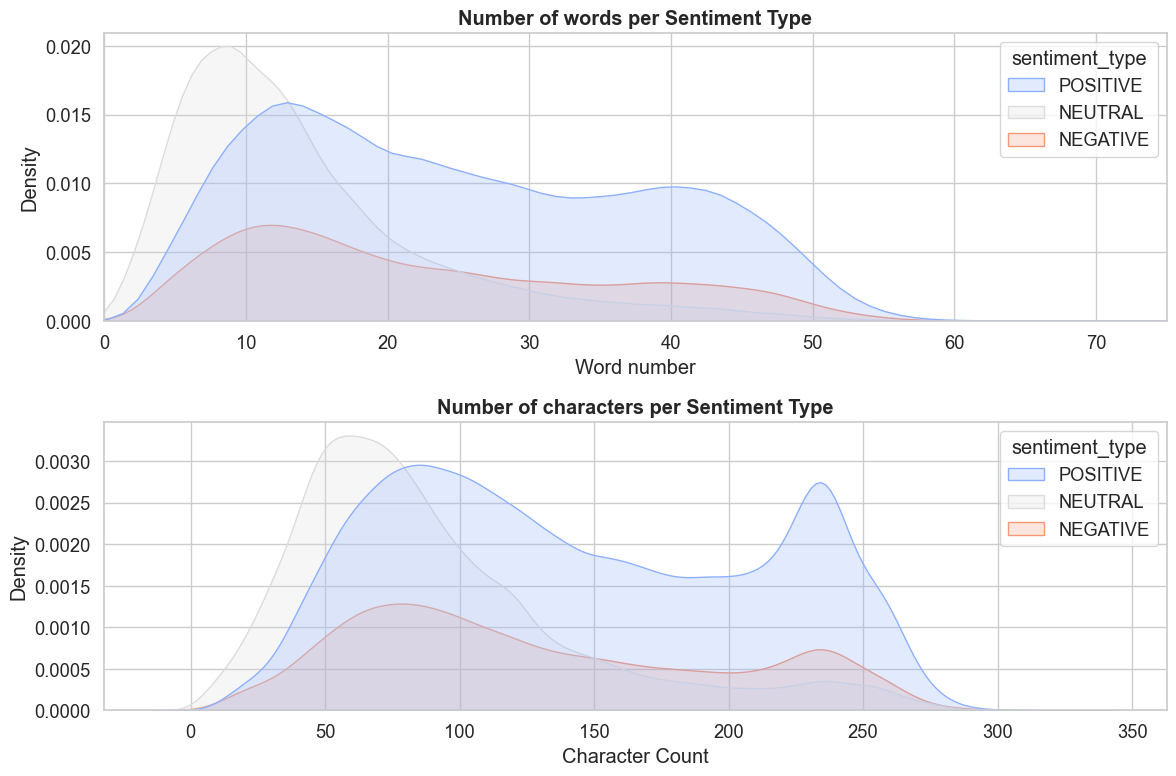

In [93]:
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid", font_scale=1.2)

plt.subplot(2, 1, 1)
sns.kdeplot(x=data['word_count'], hue=data['sentiment_type'], shade=True, palette="coolwarm")
plt.title('Number of words per Sentiment Type', fontweight='bold')
plt.xlabel('Word number')
plt.ylabel('Density')
plt.xlim(0, 75)

plt.subplot(2, 1, 2)
sns.kdeplot(x=data['char_count'], hue=data['sentiment_type'], shade=True, palette="coolwarm")
plt.title('Number of characters per Sentiment Type', fontweight='bold')
plt.xlabel('Character Count')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

# Trend analysis

In [43]:
datadate=data.copy()

datadate['created_at']=pd.to_datetime(datadate['created_at'])
datadate.set_index('created_at',inplace=True)

datadate.head()

,tweet_id,like_count,quote_count,reply_count,retweet_count,tweet,hashtag_count,word_count,char_count,stopwords_count,final_tweet,sentiment_compound_polarity,sentiment_neutral,sentiment_negative,sentiment_pos,sentiment_type
created_at,,,,,,,,,,,,,,,,
2022-11-30 18:00:15+00:00,1598014056790622225,2,0,0,0,optimizing language models dialogue,0,8,73,1,optimizing language model dialogue,0.4588,0.500,0.0,0.500,POSITIVE
2022-11-30 18:02:06+00:00,1598014522098208769,12179,889,1130,3252,try talking new ai system optimized dialogue f...,0,21,119,6,try talking new ai system optimized dialogue f...,0.8225,0.449,0.0,0.551,POSITIVE
2022-11-30 18:02:58+00:00,1598014741527527435,2,0,0,1,optimizing language models dialogue ai machine...,4,26,239,3,optimizing language model dialogue ai machinel...,0.4588,0.857,0.0,0.143,POSITIVE
2022-11-30 18:05:58+00:00,1598015493666766849,561,8,25,66,thrilled share new model optimized dialog publ...,0,22,167,8,thrilled share new model optimized dialog publ...,0.8860,0.345,0.0,0.655,POSITIVE
2022-11-30 18:06:01+00:00,1598015509420994561,1,0,0,0,2 minutes ago released new nnand use right,0,20,120,6,2 minute ago released new nnand use right,0.0000,1.000,0.0,0.000,NEUTRAL


In [44]:
datadateneg=datadate[datadate['sentiment_type']=='NEGATIVE']
datadateneg['sentiment_type']=1

datadateneu=datadate[datadate['sentiment_type']=='NEUTRAL']
datadateneu['sentiment_type']=1

datadatepos=datadate[datadate['sentiment_type']=='POSITIVE']
datadatepos['sentiment_type']=1

In [45]:
datadateneg=datadateneg.resample(rule='D').sum()
datadatepos=datadatepos.resample(rule='D').sum()
datadateneu=datadateneu.resample(rule='D').sum()

In [46]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datadatepos.index,y=datadatepos['sentiment_type'],name='Positive'))
fig.add_trace(go.Scatter(x=datadateneu.index,y=datadateneu['sentiment_type'],name='Neutral'))
fig.add_trace(go.Scatter(x=datadateneg.index,y=datadateneg['sentiment_type'],name='Negative'))
fig.update_layout(
    title={'text':"Tweet Count Trend",'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [47]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datadatepos.index,y=datadatepos['like_count'],name='Positive'))
fig.add_trace(go.Scatter(x=datadateneu.index,y=datadateneu['like_count'],name='Neutral'))
fig.add_trace(go.Scatter(x=datadateneg.index,y=datadateneg['like_count'],name='Negative'))
fig.update_layout(
    title={'text':"Like Count Trend",'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [48]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datadatepos.index,y=datadatepos['retweet_count'],name='Positive'))
fig.add_trace(go.Scatter(x=datadateneu.index,y=datadateneu['retweet_count'],name='Neutral'))
fig.add_trace(go.Scatter(x=datadateneg.index,y=datadateneg['retweet_count'],name='Negative'))
fig.update_layout(
    title={'text':"Retweet Count Trend",'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [49]:
datadateneu=datadate[datadate['sentiment_type']=='NEUTRAL']
datadateneu['sentiment_type']=1

datadateneg=datadate[datadate['sentiment_type']=='NEGATIVE']
datadateneg['sentiment_type']=1

datadatepos=datadate[datadate['sentiment_type']=='POSITIVE']
datadatepos['sentiment_type']=1

datadateneg=datadateneg.resample(rule='D').mean()
datadatepos=datadatepos.resample(rule='D').mean()
datadateneu=datadateneu.resample(rule='D').mean()

In [107]:
colors = ['rgb(31, 119, 180)', 'rgb(255, 127, 14)', 'rgb(214, 39, 40)']

fig = go.Figure()

# Add traces for positive, neutral, and negative data
fig.add_trace(go.Scatter(x=datadatepos.index, y=datadatepos['like_count'], name='Positive', line=dict(color=colors[0])))
fig.add_trace(go.Scatter(x=datadateneu.index, y=datadateneu['like_count'], name='Neutral', line=dict(color=colors[1])))
fig.add_trace(go.Scatter(x=datadateneg.index, y=datadateneg['like_count'], name='Negative', line=dict(color=colors[2])))

# Update layout and style
fig.update_layout(
    title='Like Count Avg per Tweet per Day',
    title_font=dict(size=24, color='rgb(31, 119, 180)'),
    xaxis=dict(title='Date', showgrid=False, linecolor='lightgray', mirror=True),
    yaxis=dict(title='Like Count', showgrid=False, linecolor='lightgray', mirror=True),
    legend=dict(x=0.5, y=1.05, orientation='h', font=dict(size=14)),
    plot_bgcolor='white',
    hovermode='x',
)

# Update marker size and symbol for scatter points
fig.update_traces(
    mode='lines+markers',
    marker=dict(size=8, symbol='circle'),
    hovertemplate='<b>%{y}</b> likes<br>Date: %{x}<extra></extra>'
)

fig.show()

In [105]:
# Set custom colors
colors = ['rgb(31, 119, 180)', 'rgb(255, 127, 14)', 'rgb(214, 39, 40)']

fig = go.Figure()

# Add traces for positive, neutral, and negative data
fig.add_trace(go.Scatter(x=datadatepos.index[2:22], y=datadatepos['like_count'][2:22], name='Positive', line=dict(color=colors[0])))
fig.add_trace(go.Scatter(x=datadateneu.index[2:22], y=datadateneu['like_count'][2:22], name='Neutral', line=dict(color=colors[1])))
fig.add_trace(go.Scatter(x=datadateneg.index[2:22], y=datadateneg['like_count'][2:22], name='Negative', line=dict(color=colors[2])))

# Update layout and style
fig.update_layout(
    title='Like Count Avg per Tweet per Day',
    title_font=dict(size=24, color='rgb(31, 119, 180)'),
    xaxis=dict(title='Date', showgrid=False, linecolor='lightgray', mirror=True),
    yaxis=dict(title='Like Count', showgrid=False, linecolor='lightgray', mirror=True),
    legend=dict(x=0.5, y=1.05, orientation='h', font=dict(size=14)),
    plot_bgcolor='white',
    hovermode='x',
)

# Update marker size and symbol for scatter points
fig.update_traces(
    mode='lines+markers',
    marker=dict(size=8, symbol='circle'),
    hovertemplate='<b>%{y}</b> likes<br>Date: %{x}<extra></extra>'
)

fig.show()

In [52]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datadatepos.index,y=datadatepos['retweet_count'],name='Positive'))
fig.add_trace(go.Scatter(x=datadateneu.index,y=datadateneu['retweet_count'],name='Neutral'))
fig.add_trace(go.Scatter(x=datadateneg.index,y=datadateneg['retweet_count'],name='Negative'))
fig.update_layout(
    title={'text':"Retweet Count Trend",'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()


In [53]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=datadatepos.index[:6],y=datadatepos['retweet_count'][:6],name='Positive'))
fig.add_trace(go.Scatter(x=datadateneu.index[:6],y=datadateneu['retweet_count'][:6],name='Neutral'))
fig.add_trace(go.Scatter(x=datadateneg.index[:6],y=datadateneg['retweet_count'][:6],name='Negative'))
fig.update_layout(
    title={'text':"Retweet Count Trend",'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [54]:
from transformers import RobertaTokenizerFast, TFRobertaForSequenceClassification, pipeline

In [55]:
tokenizer = RobertaTokenizerFast.from_pretrained("arpanghoshal/EmoRoBERTa")
model = TFRobertaForSequenceClassification.from_pretrained("arpanghoshal/EmoRoBERTa")

emotion = pipeline('sentiment-analysis', 
                    model='arpanghoshal/EmoRoBERTa')

emotion_labels = emotion("Thanks for using it.")
print(emotion_labels)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


[{'label': 'gratitude', 'score': 0.9964383840560913}]


In [57]:
data['emotion_labels'] = data['final_tweet'].apply(emotion)
data['emotion'] = data['emotion_labels'].apply(lambda x: x[0]['label'])
data.head()

,tweet_id,created_at,like_count,quote_count,reply_count,retweet_count,tweet,hashtag_count,word_count,char_count,stopwords_count,final_tweet,sentiment_compound_polarity,sentiment_neutral,sentiment_negative,sentiment_pos,sentiment_type,emotion_labels,emotion
0,1598014056790622225,2022-11-30 18:00:15+00:00,2,0,0,0,optimizing language models dialogue,0,8,73,1,optimizing language model dialogue,0.4588,0.500,0.0,0.500,POSITIVE,"[{'label': 'neutral', 'score': 0.7220501303672...",neutral
1,1598014522098208769,2022-11-30 18:02:06+00:00,12179,889,1130,3252,try talking new ai system optimized dialogue f...,0,21,119,6,try talking new ai system optimized dialogue f...,0.8225,0.449,0.0,0.551,POSITIVE,"[{'label': 'caring', 'score': 0.80247420072555...",caring
2,1598014741527527435,2022-11-30 18:02:58+00:00,2,0,0,1,optimizing language models dialogue ai machine...,4,26,239,3,optimizing language model dialogue ai machinel...,0.4588,0.857,0.0,0.143,POSITIVE,"[{'label': 'approval', 'score': 0.662671148777...",approval
3,1598015493666766849,2022-11-30 18:05:58+00:00,561,8,25,66,thrilled share new model optimized dialog publ...,0,22,167,8,thrilled share new model optimized dialog publ...,0.8860,0.345,0.0,0.655,POSITIVE,"[{'label': 'neutral', 'score': 0.4941824078559...",neutral
4,1598015509420994561,2022-11-30 18:06:01+00:00,1,0,0,0,2 minutes ago released new nnand use right,0,20,120,6,2 minute ago released new nnand use right,0.0000,1.000,0.0,0.000,NEUTRAL,"[{'label': 'neutral', 'score': 0.9961069226264...",neutral


In [99]:
data

,tweet_id,created_at,like_count,quote_count,reply_count,retweet_count,tweet,hashtag_count,word_count,char_count,stopwords_count,final_tweet,sentiment_compound_polarity,sentiment_neutral,sentiment_negative,sentiment_pos,sentiment_type,emotion_labels,emotion
0,1598014056790622225,2022-11-30 18:00:15+00:00,2,0,0,0,optimizing language models dialogue,0,8,73,1,optimizing language model dialogue,0.4588,0.500,0.0,0.500,POSITIVE,"[{'label': 'neutral', 'score': 0.7220501303672...",neutral
1,1598014522098208769,2022-11-30 18:02:06+00:00,12179,889,1130,3252,try talking new ai system optimized dialogue f...,0,21,119,6,try talking new ai system optimized dialogue f...,0.8225,0.449,0.0,0.551,POSITIVE,"[{'label': 'caring', 'score': 0.80247420072555...",caring
2,1598014741527527435,2022-11-30 18:02:58+00:00,2,0,0,1,optimizing language models dialogue ai machine...,4,26,239,3,optimizing language model dialogue ai machinel...,0.4588,0.857,0.0,0.143,POSITIVE,"[{'label': 'approval', 'score': 0.662671148777...",approval
3,1598015493666766849,2022-11-30 18:05:58+00:00,561,8,25,66,thrilled share new model optimized dialog publ...,0,22,167,8,thrilled share new model optimized dialog publ...,0.8860,0.345,0.0,0.655,POSITIVE,"[{'label': 'neutral', 'score': 0.4941824078559...",neutral
4,1598015509420994561,2022-11-30 18:06:01+00:00,1,0,0,0,2 minutes ago released new nnand use right,0,20,120,6,2 minute ago released new nnand use right,0.0000,1.000,0.0,0.000,NEUTRAL,"[{'label': 'neutral', 'score': 0.9961069226264...",neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219289,1609338385864478720,2022-12-31 23:59:05+00:00,0,0,0,0,software projects trying replicate,0,10,74,1,software project trying replicate,0.0000,1.000,0.0,0.000,NEUTRAL,"[{'label': 'neutral', 'score': 0.9961407780647...",neutral
219290,1609338488293363712,2022-12-31 23:59:30+00:00,5,0,1,1,asked write nye joke seos delivered nnwhy seo ...,4,42,197,15,asked write nye joke seos delivered nnwhy seo ...,0.5994,0.824,0.0,0.176,POSITIVE,"[{'label': 'desire', 'score': 0.69906878471374...",desire
219291,1609338538226757632,2022-12-31 23:59:42+00:00,7,0,0,0,disassembled dissemble,0,9,49,6,disassembled dissemble,0.0000,1.000,0.0,0.000,NEUTRAL,"[{'label': 'neutral', 'score': 0.9923290610313...",neutral
219292,1609338573056245761,2022-12-31 23:59:50+00:00,3,0,1,0,2023 predictions nothing really specific trend...,1,27,147,10,2023 prediction nothing really specific trend ...,0.0000,1.000,0.0,0.000,NEUTRAL,"[{'label': 'neutral', 'score': 0.9905319213867...",neutral


In [64]:
#most common emotions
top = Counter(data['emotion'])
temp_pos = pd.DataFrame(top.most_common(10))
temp_pos.columns = ['Common_words','count']
temp_pos.style.background_gradient(cmap='Greens')

,Common_words,count
0,neutral,140905
1,admiration,18794
2,approval,8133
3,amusement,6792
4,excitement,6539
5,surprise,4501
6,fear,3978
7,gratitude,3540
8,realization,2944
9,disapproval,2630


In [98]:
colors = px.colors.qualitative.Dark2
fig = px.treemap(temp_pos, path=['Common_words'], values='count',title='Most Common emotions')


# Update the layout
fig.update_layout(
    margin=dict(t=60, l=10, r=10, b=10),  # Adjust the margins
    plot_bgcolor='rgba(0,0,0,0)',  # Set transparent background
    paper_bgcolor='rgba(0,0,0,0)',  # Set transparent background
    font=dict(size=14, color='black'),  # Customize font size and color
    treemapcolorway=colors,  # Use custom color palette
    hoverlabel=dict(font=dict(size=16)),  # Customize hover label font size
    uniformtext=dict(minsize=12, mode='hide')  # Hide small text labels
)

# Update the color scale
fig.update_traces(
    hovertemplate='<b>%{label}</b><br>Count: %{value}<extra></extra>',  # Customize hover template
    textfont={'color': 'white'},  # Set text color to white
    texttemplate='%{label}',  # Show only the label on the treemap
    hoverinfo='label+value'  # Show label and value on hover
)
fig.show()

In [71]:
#most common emotions
top = Counter(data['emotion'])
temp_pos = pd.DataFrame(top.most_common(None))
temp_pos.drop([0],inplace=True)
temp_pos.columns = ['Common_words','count']
temp_pos.style.background_gradient(cmap='Greens')

,Common_words,count
1,admiration,18794
2,approval,8133
3,amusement,6792
4,excitement,6539
5,surprise,4501
6,fear,3978
7,gratitude,3540
8,realization,2944
9,disapproval,2630
10,joy,2588


In [76]:
fig = px.treemap(temp_pos, path=['Common_words'], values='count',title='Most Common emotions (without neutral)')
fig.show()